In [431]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy.stats
import numpy as np
from statsmodels.stats.proportion import proportion_confint

In [576]:
df = pd.read_csv('data/bquxjob_29c884e7_1949d1db4fb.csv')

In [577]:
df.dtypes

c                             int64
cleaned_mno                  object
test_status                   int64
QOS_SignalStrength            int64
Connection_Category_clean    object
dtype: object

In [579]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
10479,134,raw_3_Three Mobile,4,-101,4
14076,183,raw_Tesco Mobile_Tesco,0,-61,3
1937,28,NaN,1,-87,3
11010,18,raw_3_Three Mobile,4,-76,4
9793,24,raw_SMARTY_Smarty,4,-95,4


## Test status 0/1

In [583]:
def clean_test_status(status):
    return status.apply(lambda x: '1' if x==0 else 0)

In [584]:
df['test_status'] = clean_test_status(df['test_status'])

## Drop all but big 4 MNOs

In [580]:
df_big_four = df[df['cleaned_mno'].apply(lambda x:x in ['O2',3,'V','EE'])]

In [582]:
df_big_four.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
3226,2,EE,1,-109,5
5241,80,O2,4,-85,4
2465,14,V,4,-125,4
2755,127,V,3,-51,2
3670,5744,EE,0,-74,4


In [378]:
df.groupby('test_status')['c'].sum()

test_status
0    1426129
1    4462880
Name: c, dtype: int64

In [532]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
4149,6,O2,0,-54,4
4382,252,O2,0,-89,3
3689,75,EE,1,-128,4
3624,87,EE,0,-99,2
2575,18,V,0,-108,5


In [380]:
df[df['QOS_SignalStrength'] == -17]['c'].sum()

18

## Drop category and MNO and aggregate

In [533]:
g = df.groupby(['QOS_SignalStrength','test_status'])

In [534]:
aggregated = g.apply(lambda x: x['c'].sum())

In [535]:
pd.unique(aggregated.index.get_level_values(0))
len(pd.unique(aggregated.index.get_level_values(0)))

123

In [536]:
aggregated[aggregated.index.get_level_values(0) == -17]

QOS_SignalStrength  test_status
-17                 0              1
dtype: int64

In [537]:
aggregated.sample(10)

QOS_SignalStrength  test_status
-65                 0                948
-116                0              27998
-100                1              89780
-40                 1                  1
-52                 0                 29
-71                 0               1820
-108                1              88129
-65                 1               4823
-37                 0                  1
-123                0               4068
dtype: int64

In [538]:
n = aggregated.groupby(level=[0]).sum()

In [539]:
n.sample(5)

QOS_SignalStrength
-67     7624
-6         3
-134      95
-60     1766
-124    3683
dtype: int64

In [555]:
normalised = aggregated/ n

In [556]:
normalised.sample(5)

QOS_SignalStrength  test_status
-132                0              0.811765
-53                 1              0.724965
-48                 0              0.117647
-78                 1              0.890106
-52                 1              0.884000
dtype: float64

In [557]:
len(pd.unique(normalised.index.get_level_values(0)))

123

In [558]:
normalised = normalised[normalised.index.get_level_values(1) == '1']
# Drop failure rate

In [559]:
len(pd.unique(normalised.index.get_level_values(0)))

98

In [560]:
normalised.sample(5)

QOS_SignalStrength  test_status
-52                 1              0.884000
-104                1              0.806785
-58                 1              0.896460
-138                1              0.217391
-117                1              0.424150
dtype: float64

In [561]:
normalised = normalised.droplevel(1)

In [562]:
normalised.sample(5)

QOS_SignalStrength
-110    0.689758
-44     0.785340
-120    0.296645
-47     0.921569
-77     0.854275
dtype: float64

In [563]:
nDict = n.to_dict()

In [553]:
###normalised['n'] = map(lambda x:nDict[x],normalised.index.values)

In [564]:
normalised = pd.DataFrame(index = normalised.index, data = {'rate' : normalised.values\
                          ,'n':map(lambda x:nDict[x],normalised.index.values)})

In [565]:
normalised.sample(5)

,rate,n
QOS_SignalStrength,,
-71,0.858001,12817
-89,0.848761,59753
-118,0.376896,29077
-65,0.835730,5771
-132,0.188235,255


## Add CIs

In [566]:
proportion_confint(1,100, method = 'binom_test',alpha = 0.95)

(0.009900989118484497, 0.019801982164531506)

In [567]:
def get_ci(row):
    return proportion_confint(int(row['rate'] * row['n']), row['n'], method = 'binom_test',alpha = 0.05)

In [568]:
normalised['intervals'] = normalised.apply(get_ci,axis = 1)

In [569]:
normalised.sample(5)

,rate,n,intervals
QOS_SignalStrength,,,
-95,0.838015,89064,"(0.8355799750119836, 0.8404248258181063)"
-53,0.724965,709,"(0.6904950840502229, 0.7568057441708547)"
-124,0.199566,3683,"(0.186915537803847, 0.21284678526200315)"
-132,0.188235,255,"(0.14443111213554446, 0.24086880923972945)"
-87,0.850398,52526,"(0.8473156112972271, 0.8534268718174506)"


In [570]:
def get_db_at_rate(rate = 0.5):
    return normalised[(normalised['rate'] > rate) & (normalised.index > -130)].sort_index().index[0]
# Add a hack to exclude very low signal with high rate but low n

## Plot (Full Dataset)

In [571]:
normalised['intervals'].sample(5)

QOS_SignalStrength
-110    (0.6870873471476642, 0.6924156881816836)
-124    (0.186915537803847, 0.21284678526200315)
-134    (0.1627609915839891, 0.3414250203863437)
-70       (0.88406714555188, 0.8963399426951186)
-62     (0.8781802171836595, 0.9015795946860419)
Name: intervals, dtype: object

In [572]:
def plot_rate(normalised, name = 'plot'):
    ax = plt.subplot()
    
    x_lims = [-140,-40]
    
    main_colour = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    
    normalised.plot(kind = 'line', ax = ax, y = 'rate', legend = False)
    # Plot rate
    
    plt.title('n = {:.1f} k'.format(normalised['n'].sum()/1000.))
    # Label with total sample size
    
    ax.fill_between(normalised.index, normalised['intervals'].apply(lambda x:x[0]), normalised['intervals'].apply(lambda x:x[1]), alpha = 0.5)
    # Add CIs
    
    for rate in [0.5, 0.75, 0.85]:
        plt.plot([get_db_at_rate(rate), get_db_at_rate(rate)],[0,rate], color = 'grey', linestyle = '--')
        plt.plot([x_lims[0],get_db_at_rate(rate)], [rate,rate], color = 'grey', linestyle = '--')
    
        plt.annotate('{:d}% : {:d} dB'.format(int(rate * 100), get_db_at_rate(rate)),xy = (-139, rate + 0.015),xycoords = 'data', color = 'grey')
    # Add annotations and lines at certain rates
    
    plt.xlim(x_lims)
    plt.ylim([0.0,1.0])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Drop frame
    
    plt.ylabel('Connectivity Success Rate')
    plt.xlabel('Signal Strength (dB)')
    # Label
    
    plt.savefig('figs/{:s}.png'.format(name),dpi = 300)
    plt.savefig('figs/{:s}.svg'.format(name))
    # Save

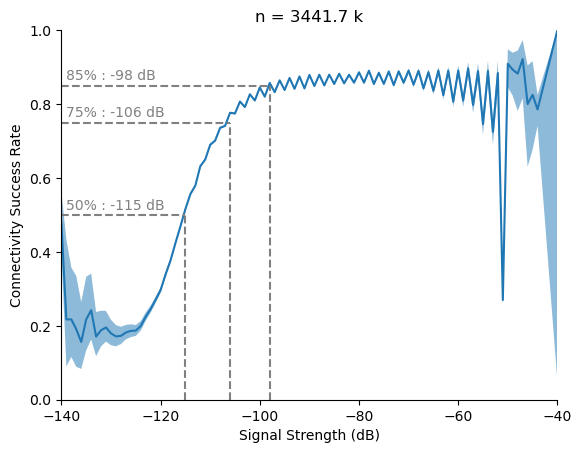

In [573]:
plot_rate(normalised,name = 'plot_big_4')

## Plot by MNO

In [574]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
4428,1,O2,0,-115,5
3524,2302,EE,0,-116,4
4391,328,O2,1,-56,4
2713,3,V,0,-72,4
4987,29,O2,0,-91,3


In [575]:
g = df.groupby(['QOS_SignalStrength','test_status','cleaned_mno'])